# Case Study 4

#### Josh Eysenbach, Anish Patel, Sreeni Prabhala
#### June 21, 2021

### Abstract

In this case study, we build a predictive model for determining what factors could indicate that a company will go bankrupt. We begin with a random forest model to establish a baseline for a more sophisticated boosted model, which ultimately provides the best performance.

### 1   Introduction

Maximizing profits is the obvious central pursuit of every business, but its antithesis of equal import is Bankruptcy - the inability to generate enough revenue to operate and pay off debts. Bankruptcy, as it is the ultimate culmination of issues leading to economic collapse of a company, warrants careful analysis to seek its portents. 

This case study aims to build a classification model that predicts whether a company will enter bankruptcy, based on a wide array of collected economic information about those companies. The data provided originates from a 2016 paper evaluating Polish companies [1]. The economic data the authors collected for the evaluated companies came from an international institute for research of emerging markets called *EMIS* [2]. The data for the analyzed bankrupt companies comes from the period 2000-2012, while the data for companies still in operation came from 2007 to 2013. The authors built an Extreme Gradient Boosting model using "synthetic features" they created from the accumulated data which they described as "a combination of the econometric measures using arithmetic operations (addition, subtraction, multiplication, division)" [1]. These synthetic features were used as the predictors in their model, and this case study deploys similar methods using the same synthetic features they derived. The authors conducted their analysis of each separate year in a five year forecasting period, but this case study only models the cumulative data from all five years collectively.

### 2   Methods

#### Data Acquisition and Cleanup
 
The data used in this case study as provided by the aforementioned authors is requisitioned from the UCI Machine Learning database website [3]. The dataset in its original form is provided as five comma separated ".arff" files for each of the five years of the forecast period; these were first combined in excel into a single .csv file for this cumulative analysis. There are no names, keys, or indicators of any kind for the included instances that each represent an evaluated company, and the data is purely based on economic indicators with no references to company sizes, types, industries, or vintages. All feature data is quantitative. The 64 column names in the dataset use numbered keys (Example: *X21*) instead of the full description of the synthetic feature, for simplicity and ease of use with coding.  The full names of each synthetic feature are included in **Appendix A**. The target class is *Y*, which represents a bankruptcy with "1". 

It was noticed in the initial combination and exploration of the data in excel that missing data is represented as "?". These characters were replaced with *null* (NaN) for missing data anlysis as the data in its entirety was simultaneously coerced to numeric. Based on visual inspection of the missing values, there appeared to be very few features with large amounts of missing data. All missing values for each feature were replaced with the median of the existing data for that feature. The mean was not used as some of the features have extreme outliers that could influence the mean. It was also determined that there were not any other features that could be used with significant benefit to predictively impute the missing values in the few features with a high number of missing data. See appendix for summary stats, correlation plots, and box plots that demonstrate this.

The dataset has various metrics that are of different magnitudes. However, as the tree-based ensemble methods can handle this data effectively, we have decided against scaling these metrics.


#### Data Imbalance

When we look at the distribution of the target outcome (i.e. whether a company went bankrupt or not), we see that the data is heavily imbalanced. As we would expect, the proportion of companies that went bankrupt is significantly less compared to the ones that did not.

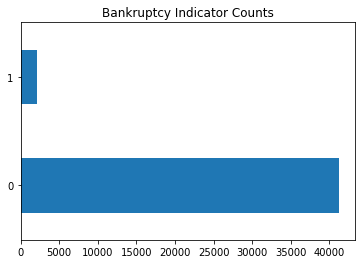

This calls for certian considerations during the model training activities. To start with, we have utilized stratified splitting technique during the train-test split process to ensure the proportion of target vriable remains same in both the train and test data sets. We have used the same technique for the split processes employed during the cross validation and grid-search processes that are part of the model training activiity.

The purpose of this modeling exercise is to predict companies that may go bankrupt so that the business can make relevant divestiture decisions to minimize loss. As such, we need to minimize false-negatives (i.e. mis-classifying the companies that went bankrupt), and so we have used the *recall* metric to compare the models during hyperparameter tuning, as the recall is the percentage of total positively identified bankruptcies correctly classified by the algorithm.

In addition, we have used the precision-recall curve to obtain the optimum probability threshold value while classifying the data based on target probability values with the optimized boosted model.

#### Random Forest Model

The modified dataset was first split into training and test sets with 20% of the data reserved for the test set. The target class is heavily imbalanced as discussed above, with only about 5% of the outcomes being bankruptcy. So the test/train split was accomplished using the *stratified* option to maintain the ratio of outcomes. This also meant that using methods to balance the classes in model building would be imperative.

The Random Forest Model was tuned using *GridSearchCV* to iterate through different possible hyperparameter combinations. The primary metric for training the model and evaluating the hyperparameter combinations was the recall of the classification (the proportion of incorrectly identified bankruptcies). The grid search ran models using the training set and the results of each combination were validated internally using 5-fold cross validation to identify the best combination. The four hyperparameters explored with this method were as follows:

- *n_estimators*: The number of trees in the forest.
- *max_features*: The number of features to consider when looking for the best split.
- *criterion*: Gini or Entropy; The function used to evaluate the quality of a split.
- *max_depth*: The maximum depth of the tree.

After the best combination of hyperparameters was identified, the model was run on the test set to assess the both the overall accuracy of the model, and the recall for comparison to more sophisticated boosted models. The feature importances could also be run to determine which of the synthetic features were most important in the random forest model.

#### Boosted Model

To assess the performance of a boosted model against the Random Forest Model, we next trained the data on XGBoost (eXtreme Gradient Boosting) classifier. As our target is binary, we used the learning objective function *binary:logistic*, which returns the probabilities for a positive classification as predictions. We then used the optimum threshold obtained from the precision-recall curve to convert the probabilites into classification values.

We used 500 as the number of boosting rounds and have configured the model to stop after 2 training iterations in case there is no improvement in the performance on the test dataset (to avoid overfitting of the model to training data). In addition, we have tuned following parameters using *RandomizedSearchCV* to iterate through a random set of possible combinations of the parameters:

- *max_depth*: The maximum depth of the tree.
- *eta*: Step size shrinkage used to prevent overfitting

After the best combination of hyperparameters was identified, the model was run on the test set to assess the accuracy for comparison to the best Random Forest model.

*RandomizedSearchCV* was also run on the random forest model to compare to the full *GridSearchCV* method of hyperparameter tuning. *RandomizedSearchCV* results in significant execution time gain compared to *GridSearchCV* without compromising too much on the model performance. While this possibly may not find the best possible combination, it is the preferred hyperparameter tuning technique for models that are computationally intensive like XGBoost. The *GridSearchCV* method took several hours to complete in initial runs with all of the tested hyperparameters, compared to minutes using *RandomizedSearchCV*.

*See Appendix A for a list of Feature Descriptions*

### 3   Results

#### Random Forest Model

In hyperparameter tuning of the random forest model, the best combination was able to achieve a recall of about .62 on the classification of bankruptcy ("1") with an accuracy of **95%** on the test set. Interestingly, this was achieved with a high number of estimators (500) but a shallow max depth of each tree of only 10. It must be noted as well that the difference in the scores (by recall) were very close and when the grid search was run multiple times, sometimes the best combination changed slightly - there were several runs that suggested 200 estimators as the best option.

The top three most important features were *profit on operating activities / financial expenses*, *operating expenses / total liabilities*, and *gross profit (in 3 years) / total assets*. Without specific domain knowledge, it is difficult to interpret these with much competency, but they make sense intuitively. The proportions of profit to expenses and expenses to liabilities would be intuitively important economic indicators that could signal potential bankruptcy, as they are generally common measurements for company performance. The complete details of feature relevance for the model are depicted below.

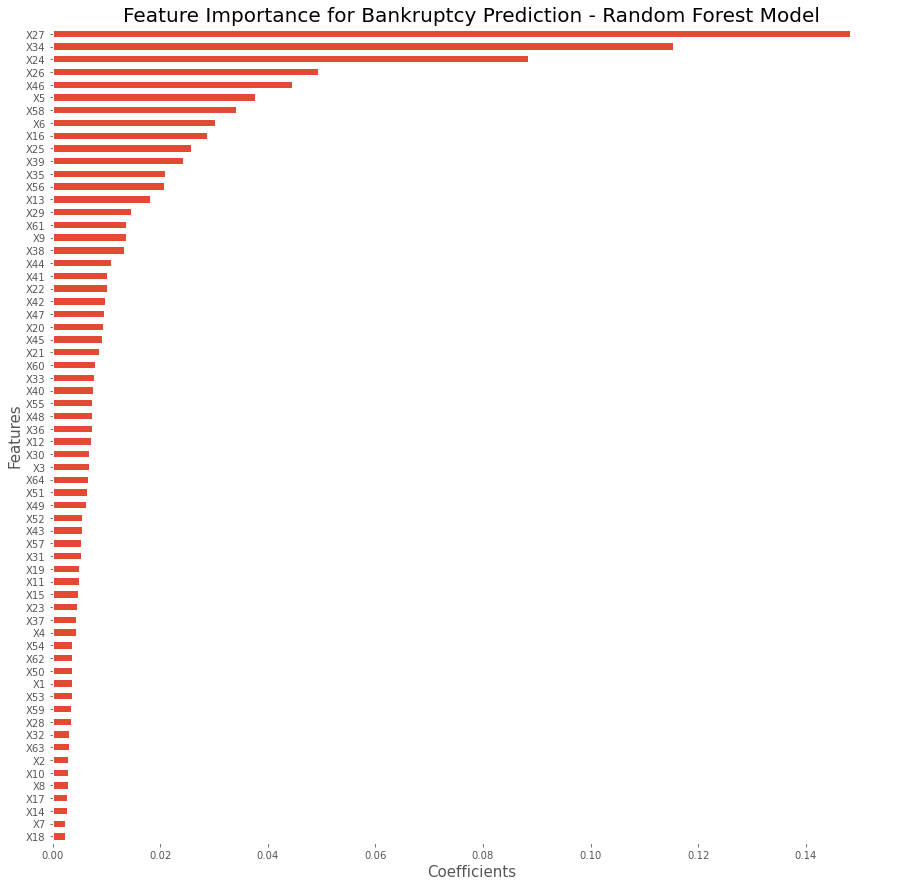

#### XGBoost Model

The best XGBoost model obtained using the hjyperparameter tuning was able to achieve a recall of .51 with an accuracy of **98%** on the test dataset. This is a significant enough gain in both the metrics compared to the Random Forest model. The cross-validation of the best model reached early stopping after around 140 rounds of training.

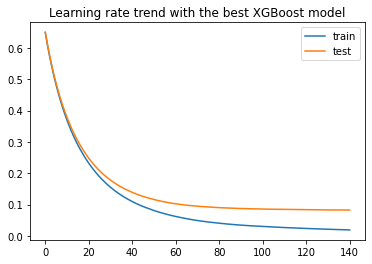

As our target is a binary variable, and we have used the *binary:logistic* learning objective, the model predicted probabilities for the positive classification. We have then employed precision-recall curve (depicted below) to assess the optimum threshold. Based on this plot, we have used a threshold of 0.1 to classify the positive outcome to calculate the accuracy score.

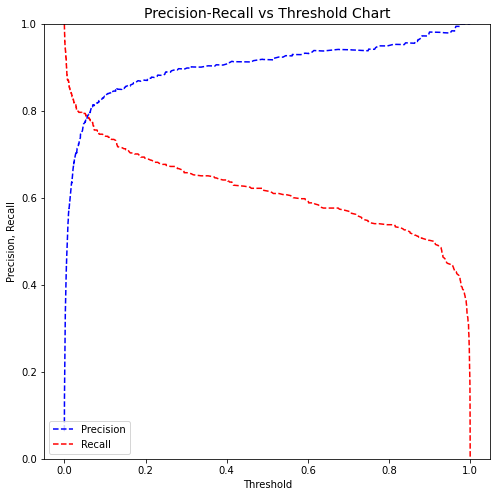

The top three most important features for XGBoost model were *operating expenses / total liabilities*, *(net profit + depreciation) / total liabilities* and *retained earnings / total assets*. The complete feature relevance details for the model are depicted below.

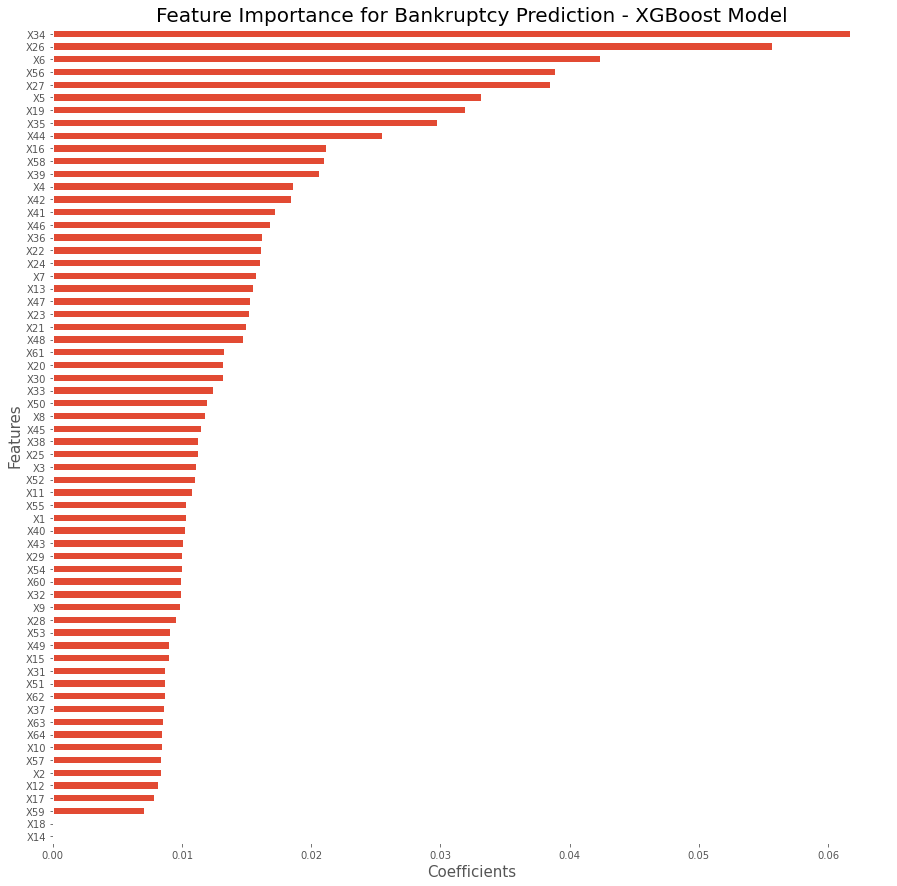

### 4   Conclusion

With effective hyperparameter tuning, advanced boosting algorithms like XGBoost result in better model performance compared to the Random Forest model. In this exercise, due to the time and resource constraints, we have used a limited set of parameters and options to tune the hyperparameters. With more time and more powerful computing resources, this could no doubt be improved futher with more tuning. Regardless, the accuracy improvement using the boosted model with limited tuning was still notably better.

The most important features in the random forest model were somewhat similar to those in the boosted, but the feature *profit on operating activities / financial expenses*, which was the most important by far in the random forest model, was considerably lower using boosted methods. It would be interesting to see if running multiple times with some slight hyperparameter changes would shift the features of most importance around. The XGboost model appears to show more "spread" of importance among the included variables versus the random forest which had just a few highly used features and then a stark drop off in use of the others.

Another important point demonstrated was the potential of the randomized cross validated hyperparameter search. This was a helpful demonstration of how much time can be saved by way of using this method to drastically cut down the total number of combinations tested, but with the caveat that the best combination may not be found as we saw when attempting with the random forest model in this study.

### Appendix A:   Feature Labels

| Data Label | Feature Description |
| --- | :-: |
| X1 | net profit / total assets |
| X2 | total liabilities / total assets |
| X3 | working capital / total assets |
| X4 | current assets / short-term liabilities |
| X5 | [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 |
| X6 | retained earnings / total assets |
| X7 | EBIT / total assets |
| X8 | book value of equity / total liabilities |
| X9 | sales / total assets |
| X10 | equity / total assets |
| X11 | (gross profit + extraordinary items + financial expenses) / total assets |
| X12 | gross profit / short-term liabilities |
| X13 | (gross profit + depreciation) / sales |
| X14 | (gross profit + interest) / total assets |
| X15 | (total liabilities * 365) / (gross profit + depreciation) |
| X16 | (gross profit + depreciation) / total liabilities |
| X17 | total assets / total liabilities |
| X18 | gross profit / total assets |
| X19 | gross profit / sales |
| X20 | (inventory * 365) / sales |
| X21 | sales (n) / sales (n-1) |
| X22 | profit on operating activities / total assets |
| X23 | net profit / sales |
| X24 | gross profit (in 3 years) / total assets |
| X25 | (equity - share capital) / total assets |
| X26 | (net profit + depreciation) / total liabilities |
| X27 | profit on operating activities / financial expenses |
| X28 | working capital / fixed assets |
| X29 | logarithm of total assets |
| X30 | (total liabilities - cash) / sales |
| X31 | (gross profit + interest) / sales |
| X32 | (current liabilities * 365) / cost of products sold |
| X33 | operating expenses / short-term liabilities |
| X34 | operating expenses / total liabilities |
| X35 | profit on sales / total assets |
| X36 | total sales / total assets |
| X37 | (current assets - inventories) / long-term liabilities |
| X38 | constant capital / total assets |
| X39 | profit on sales / sales |
| X40 | (current assets - inventory - receivables) / short-term liabilities |
| X41 | total liabilities / ((profit on operating activities + depreciation) * (12/365)) |
| X42 | profit on operating activities / sales |
| X43 | rotation receivables + inventory turnover in days |
| X44 | (receivables * 365) / sales |
| X45 | net profit / inventory |
| X46 | (current assets - inventory) / short-term liabilities |
| X47 | (inventory * 365) / cost of products sold |
| X48 | EBITDA (profit on operating activities - depreciation) / total assets |
| X49 | EBITDA (profit on operating activities - depreciation) / sales |
| X50 | current assets / total liabilities |
| X51 | short-term liabilities / total assets |
| X52 | (short-term liabilities * 365) / cost of products sold) |
| X53 | equity / fixed assets |
| X54 | constant capital / fixed assets |
| X55 | working capital |
| X56 | (sales - cost of products sold) / sales |
| X57 | (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation) |
| X58 | total costs /total sales |
| X59 | long-term liabilities / equity |
| X60 | sales / inventory |
| X61 | sales / receivables |
| X62 | (short-term liabilities * 365) / sales |
| X63 | sales / short-term liabilities |
| X64 | sales / fixed assets |
| Y | (**Target**) "1" indicates Bankrupt company |

### Appendix B:   Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#import data
df = pd.read_csv("https://raw.githubusercontent.com/jteysen/QTW/main/Data/CS_4/CS4_Combined_Data.csv")

In [3]:
df.shape

(43405, 66)

In [4]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Company  43405 non-null  int64 
 1   X1       43405 non-null  object
 2   X2       43405 non-null  object
 3   X3       43405 non-null  object
 4   X4       43405 non-null  object
 5   X5       43405 non-null  object
 6   X6       43405 non-null  object
 7   X7       43405 non-null  object
 8   X8       43405 non-null  object
 9   X9       43405 non-null  object
 10  X10      43405 non-null  object
 11  X11      43405 non-null  object
 12  X12      43405 non-null  object
 13  X13      43405 non-null  object
 14  X14      43405 non-null  object
 15  X15      43405 non-null  object
 16  X16      43405 non-null  object
 17  X17      43405 non-null  object
 18  X18      43405 non-null  object
 19  X19      43405 non-null  object
 20  X20      43405 non-null  object
 21  X21      43405 non-null  object
 22

In [5]:
df.head()

,Company,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,1,0.20055,0.37951,0.39641,2.0472,32.351,0.38825,0.24976,1.3305,1.1389,...,0.12196,0.39718,0.87804,0.001924,8.416,5.1372,82.658,4.4158,7.4277,0
1,2,0.20912,0.49988,0.47225,1.9447,14.786,0,0.25834,0.99601,1.6996,...,0.1213,0.42002,0.853,0,4.1486,3.2732,107.35,3.4,60.987,0
2,3,0.24866,0.69592,0.26713,1.5548,-1.1523,0,0.30906,0.43695,1.309,...,0.24114,0.81774,0.76599,0.69484,4.9909,3.951,134.27,2.7185,5.2078,0
3,4,0.081483,0.30734,0.45879,2.4928,51.952,0.14988,0.092704,1.8661,1.0571,...,0.054015,0.14207,0.94598,0,4.5746,3.6147,86.435,4.2228,5.5497,0
4,5,0.18732,0.61323,0.2296,1.4063,-7.3128,0.18732,0.18732,0.6307,1.1559,...,0.13485,0.48431,0.86515,0.12444,6.3985,4.3158,127.21,2.8692,7.898,0


In [6]:
#Missing Values are indicated by "?" in the original data. Coerce all data to numeric - this will change "?" to NaN
df = df.apply(pd.to_numeric, errors='coerce')

In [7]:
#Now the missing values are visible and features are numeric
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  43405 non-null  int64  
 1   X1       43397 non-null  float64
 2   X2       43397 non-null  float64
 3   X3       43397 non-null  float64
 4   X4       43271 non-null  float64
 5   X5       43316 non-null  float64
 6   X6       43397 non-null  float64
 7   X7       43397 non-null  float64
 8   X8       43311 non-null  float64
 9   X9       43396 non-null  float64
 10  X10      43397 non-null  float64
 11  X11      43361 non-null  float64
 12  X12      43271 non-null  float64
 13  X13      43278 non-null  float64
 14  X14      43397 non-null  float64
 15  X15      43369 non-null  float64
 16  X16      43310 non-null  float64
 17  X17      43311 non-null  float64
 18  X18      43397 non-null  float64
 19  X19      43277 non-null  float64
 20  X20      43278 non-null  float64
 21  X21      375

In [8]:
#verify in excel
#df_2.to_csv('data_check.csv')

#### Missing Values

The plots below visualize any missing values as white space to easily identify features with large amounts of missing data.

<AxesSubplot:>

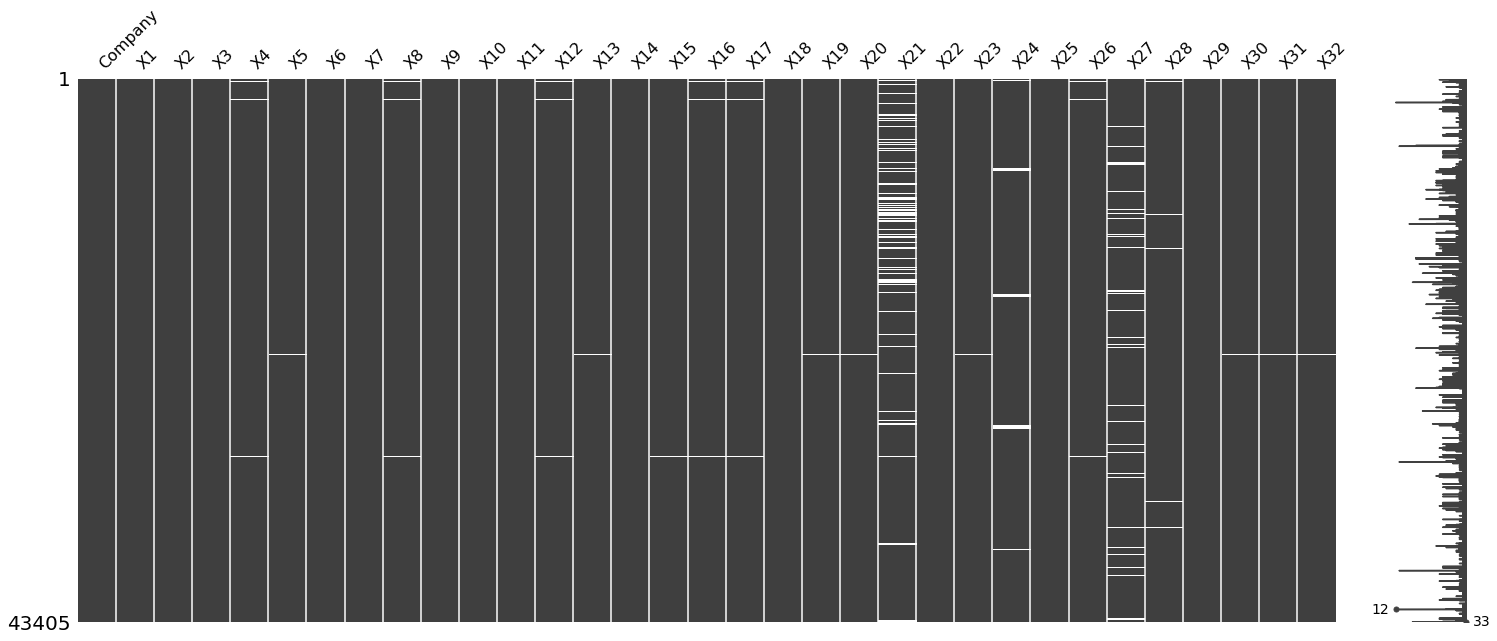

In [9]:
#look at missing values (first 32 features)
msno.matrix(df.iloc[:, 0:33])

<AxesSubplot:>

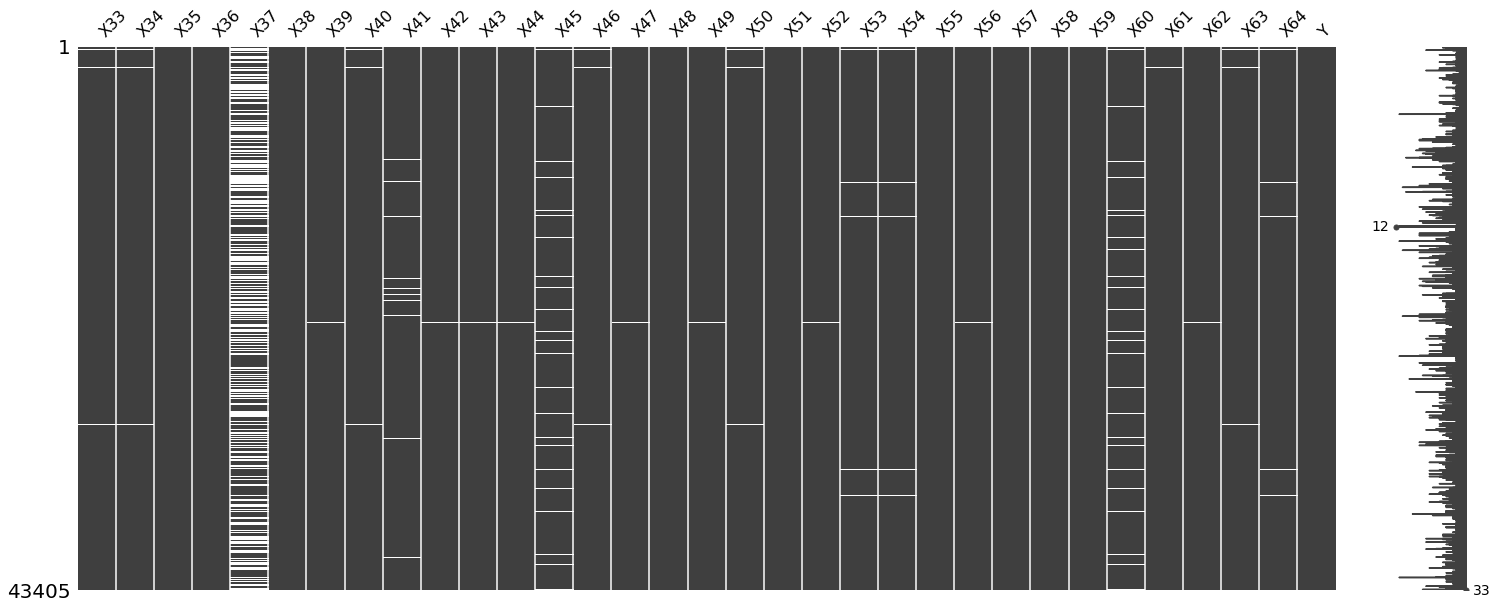

In [10]:
#look at missing values (features X33 to X64 and class)
msno.matrix(df.iloc[:, 33:66])

Only two columns appear to have a large number of missing values but should still be okay to replace all missing values with the median of the values in that column - see summary stats and plots below that indicate that the mean may be a poor choice due to extreme outliers and large ranges. See also the correlation plot below that does not show any correlation between X37 (that with the most missing data) and any other features, so imputing by prediction from another feature would not be useful.

<AxesSubplot:>

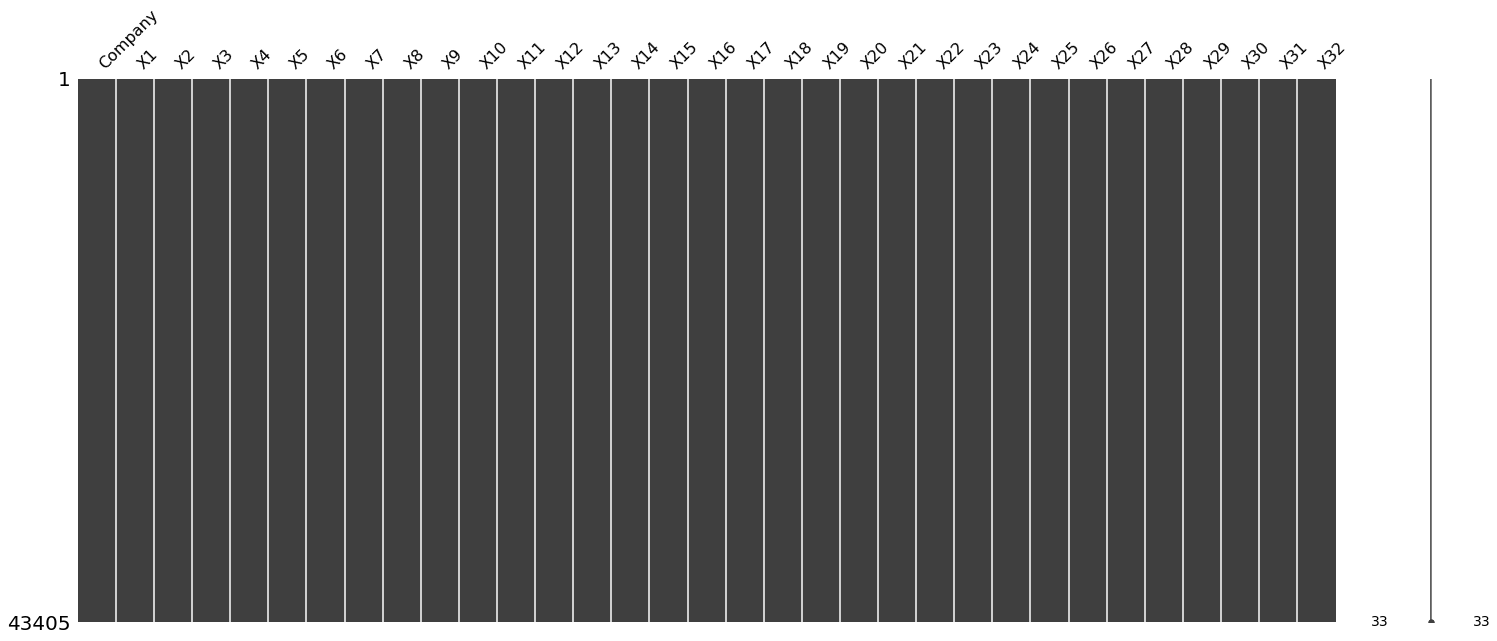

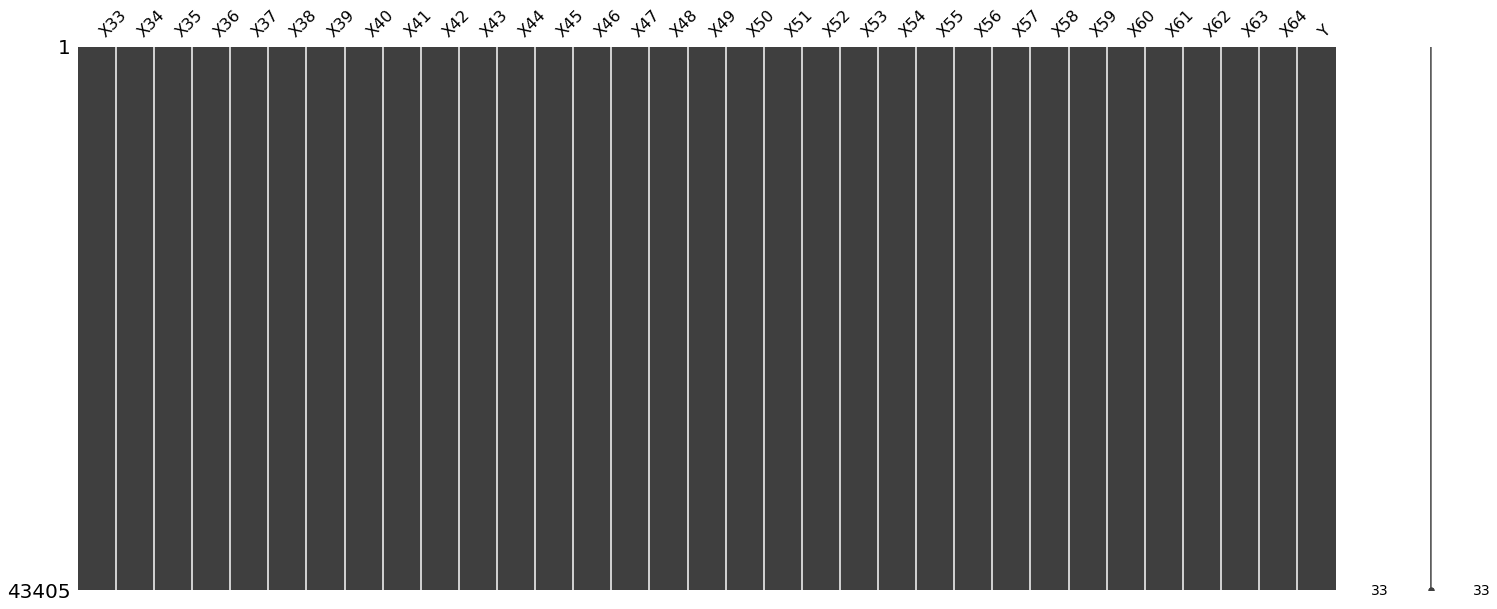

In [11]:
#impute missing values with mean from their respective columns
df = df.apply(lambda x: x.fillna(x.median()),axis=0)
#check for no more missing values
msno.matrix(df.iloc[:, 0:33])
msno.matrix(df.iloc[:, 33:66])

#### Data Exploration

In [12]:
#summary stats - large differing ranges of values for different features; normalization would be needed for linear methods, 
# but should not be an issue with RF
df.describe()

,Company,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
count,43405.000000,43405.000000,43405.00000,43405.000000,43405.000000,4.340500e+04,43405.000000,43405.000000,43405.000000,43405.000000,...,4.340500e+04,43405.000000,4.340500e+04,43405.000000,4.340500e+04,43405.000000,4.340500e+04,43405.000000,43405.000000,43405.000000
mean,21703.000000,0.035162,0.59019,0.114446,6.300054,-3.845600e+02,-0.056097,0.093472,12.615721,2.651864,...,-2.614272e+01,-0.010489,2.997018e+01,1.333074,4.263752e+02,17.008770,1.498334e+03,9.329937,71.514385,0.048174
std,12530.088554,2.993833,5.84221,5.438928,294.978147,6.116516e+04,7.200663,5.712548,505.346463,62.926210,...,5.320062e+03,13.672969,5.329289e+03,122.094600,3.153328e+04,552.399416,1.390984e+05,123.985746,2347.491761,0.214137
min,1.000000,-463.890000,-430.87000,-479.960000,-0.403110,-1.190000e+07,-508.410000,-517.480000,-141.410000,-3.496000,...,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.340000e+06,-1.543200,-10677.000000,0.000000
25%,10852.000000,0.003434,0.26901,0.021540,1.050800,-4.896200e+01,0.000000,0.005783,0.431070,1.018500,...,9.461000e-03,0.014661,8.755400e-01,0.000000,5.729400e+00,4.515600,4.220500e+01,3.100200,2.207800,0.000000
50%,21703.000000,0.049660,0.47190,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,...,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500,0.000000
75%,32554.000000,0.129560,0.68827,0.403260,2.783600,5.046100e+01,0.089441,0.150810,2.609200,2.062400,...,1.287800e-01,0.284570,9.925800e-01,0.235870,1.921900e+01,10.378000,1.169800e+02,8.577500,9.559100,0.000000
max,43405.000000,94.280000,480.96000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,...,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000,1.000000


<AxesSubplot:>

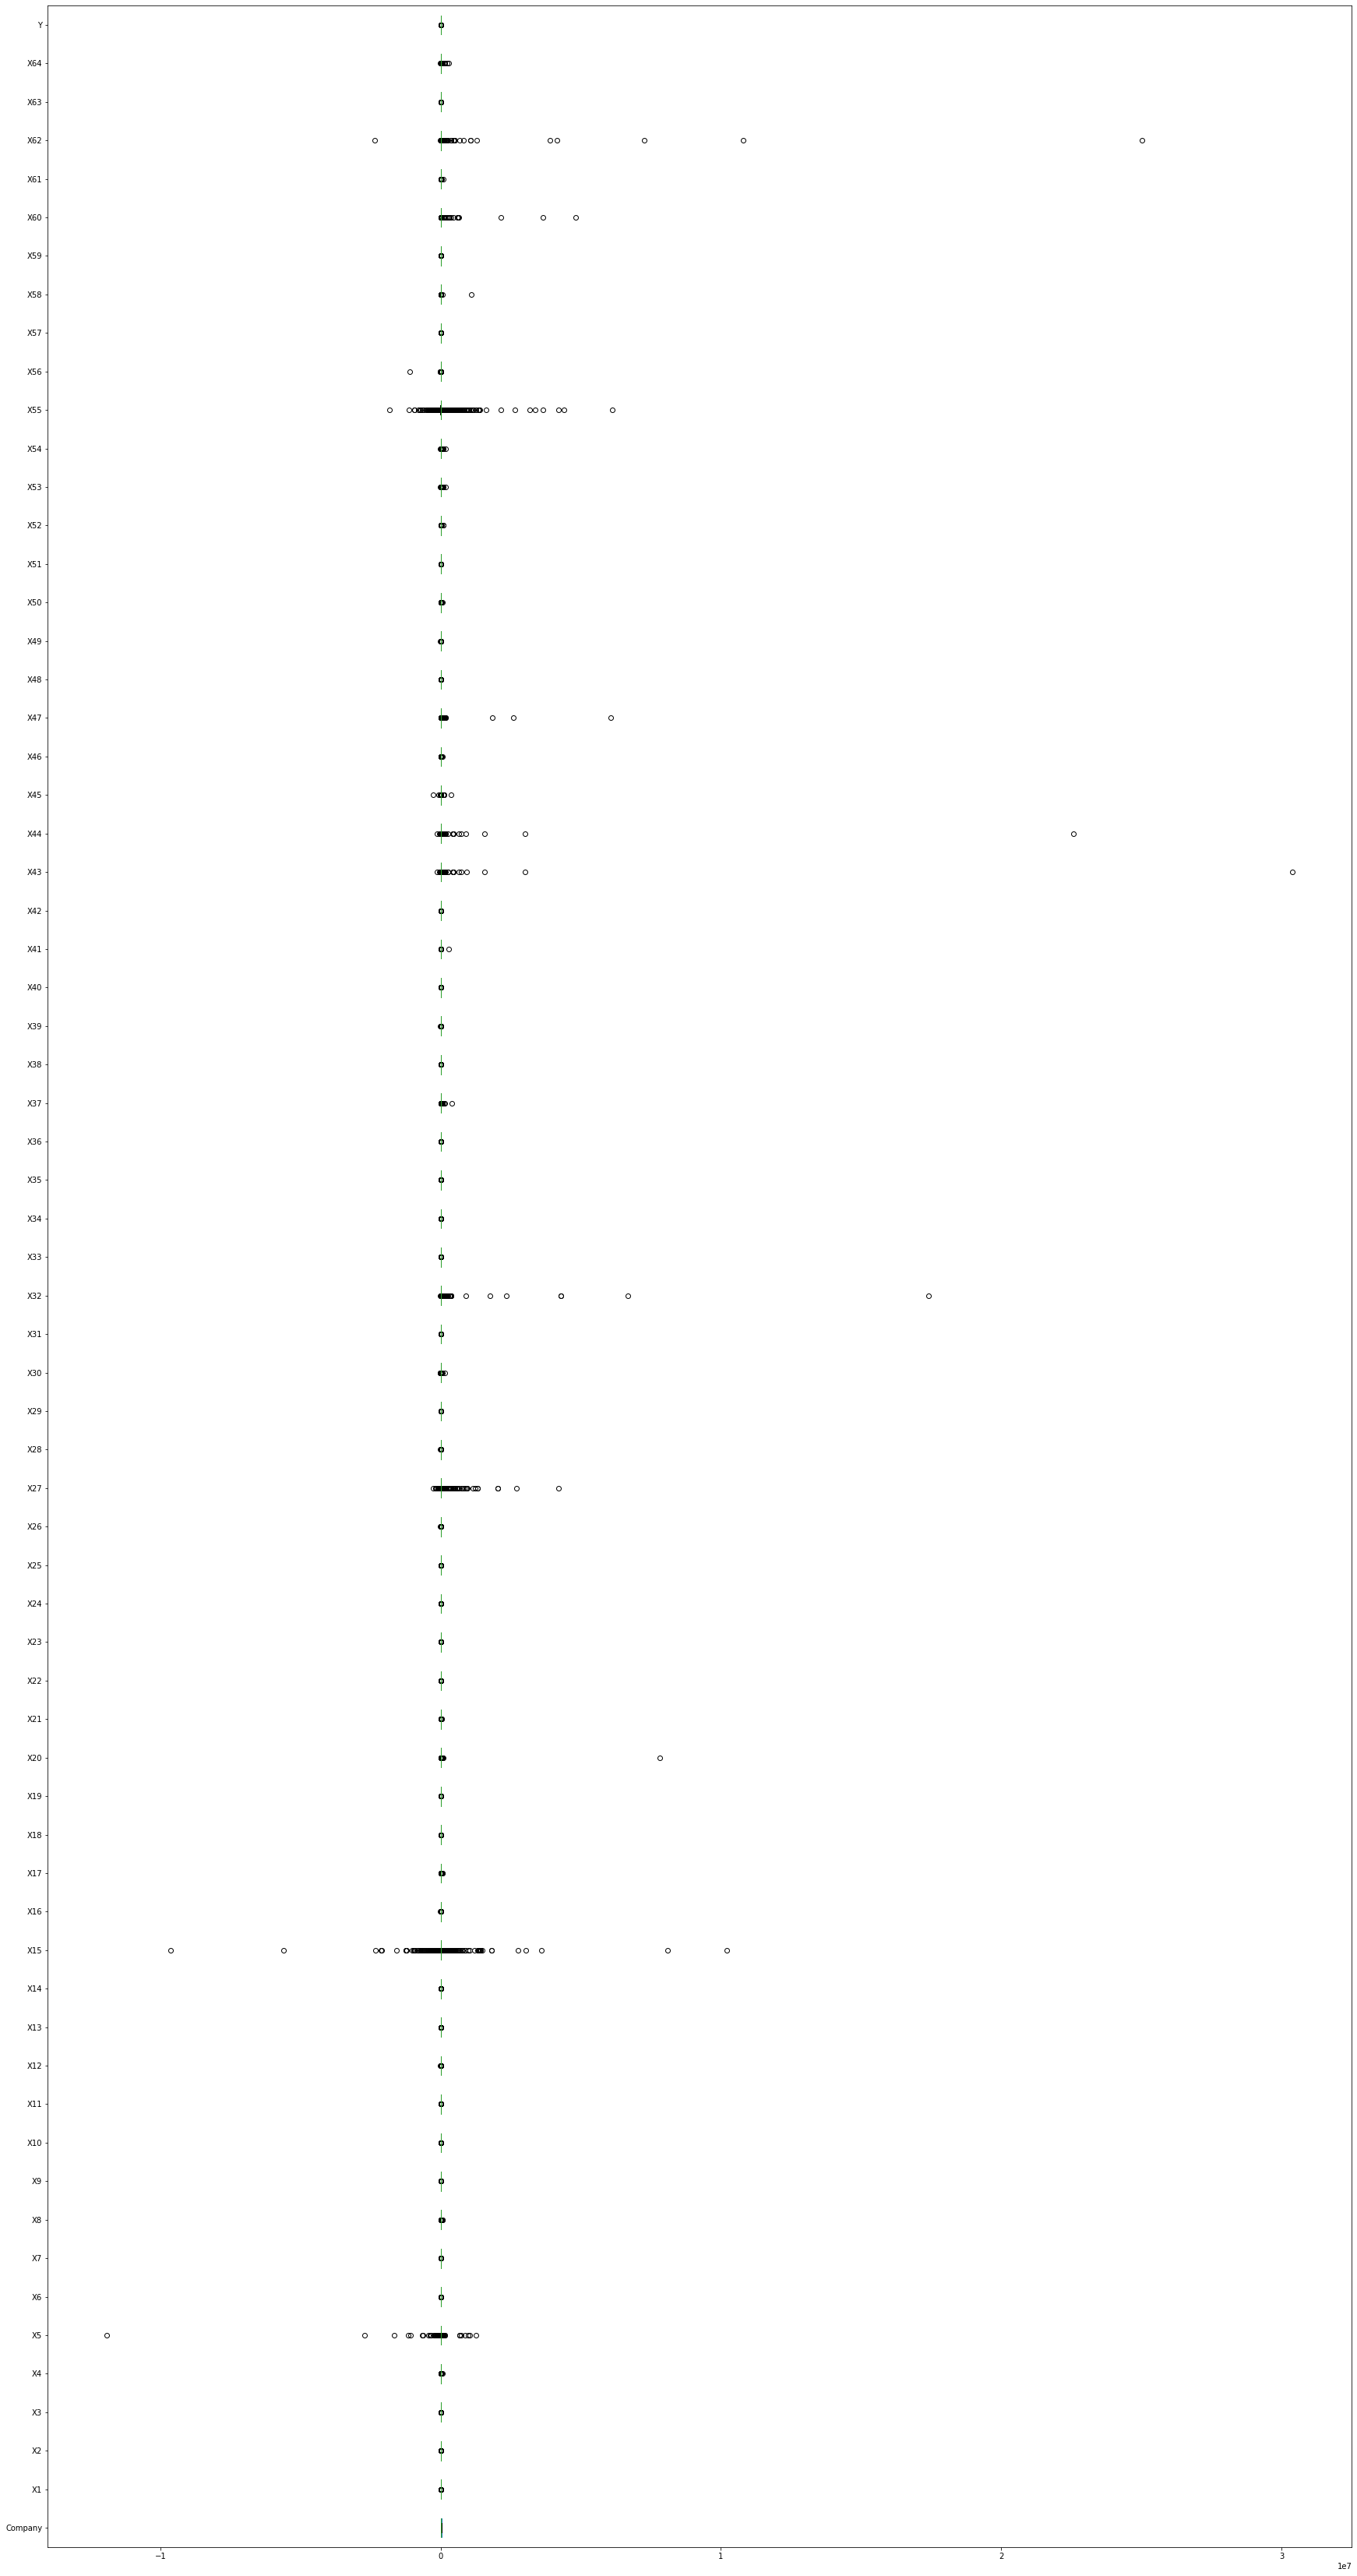

In [21]:
#The boxplots demonstrate that there are some extreme outliers in the data, but this should not be an issue using RF and boosting
#Useful to know for missing values imputation - probably safer to use the median instead of the mean
df.plot.box(vert = False, grid = False, figsize = (30,60))

Text(0.5, 1.0, 'HeatMap-Correlation Matrix')

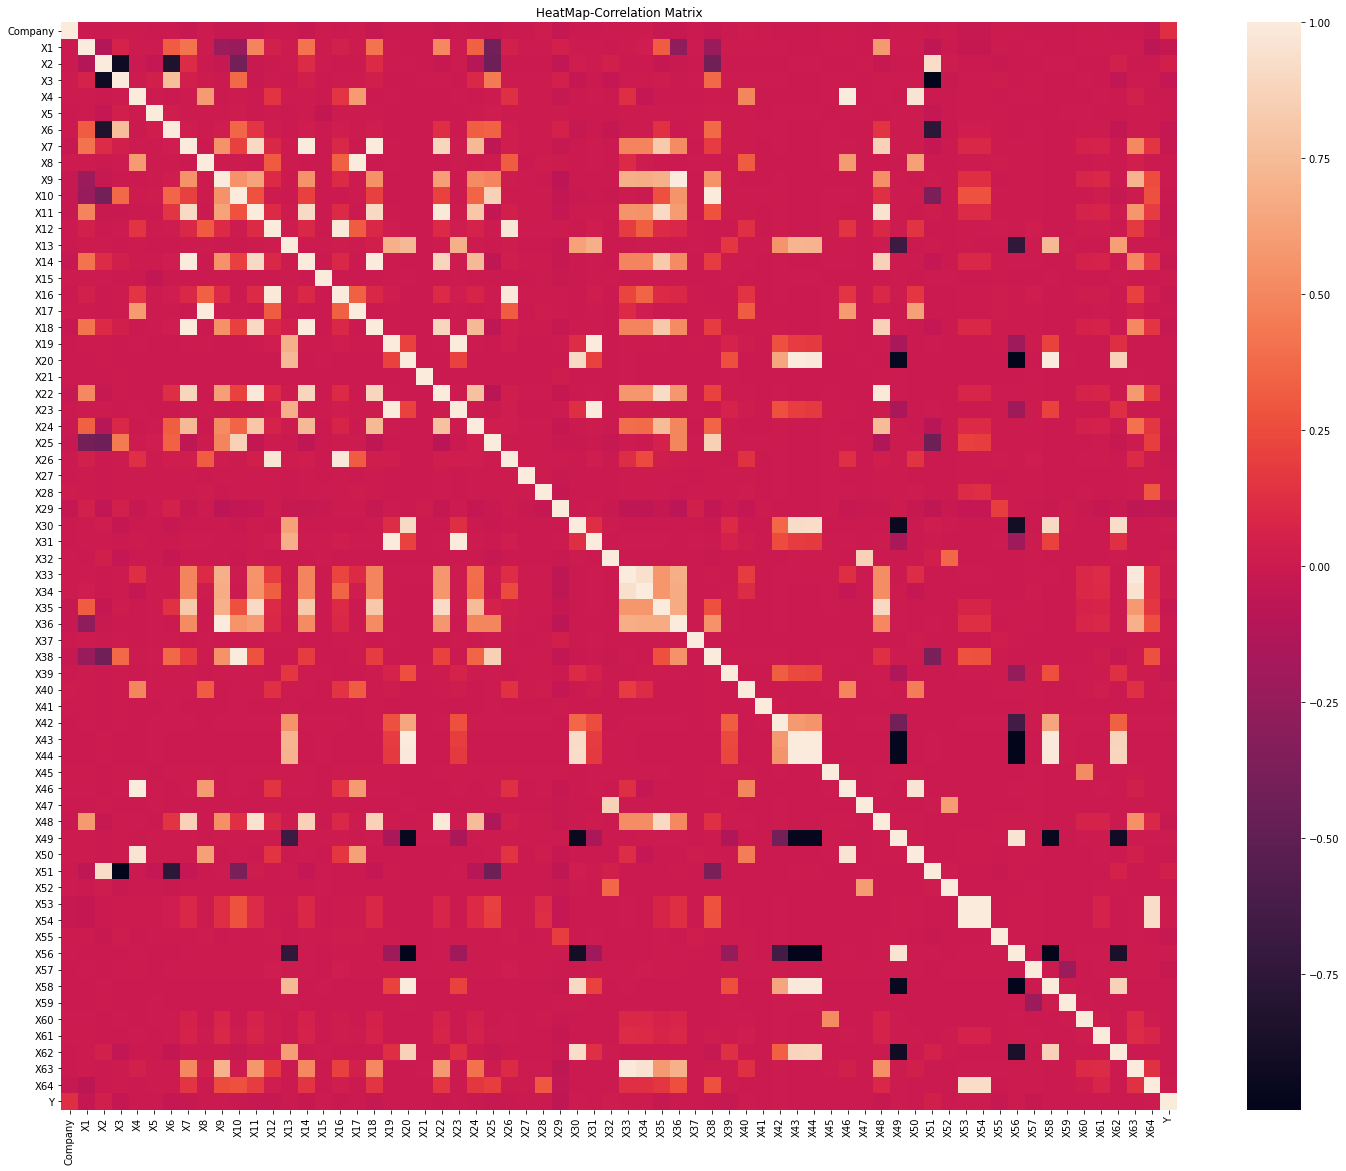

In [14]:
#correlations between features - not necessarily an issue with RF and boosting, but could give insight into potential branches
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=False)
plt.title('HeatMap-Correlation Matrix')

As the features are synthetically derived from economic factors, we should expect some correlation between features that are functions of similar factors. We can see that some are almost perfectly correlated with each other, but this shouldn't be an issue with Random Forest and Boosted models.

Text(0.5, 1.0, 'HeatMap-Correlation Matrix with Missing Values (No imputation)')

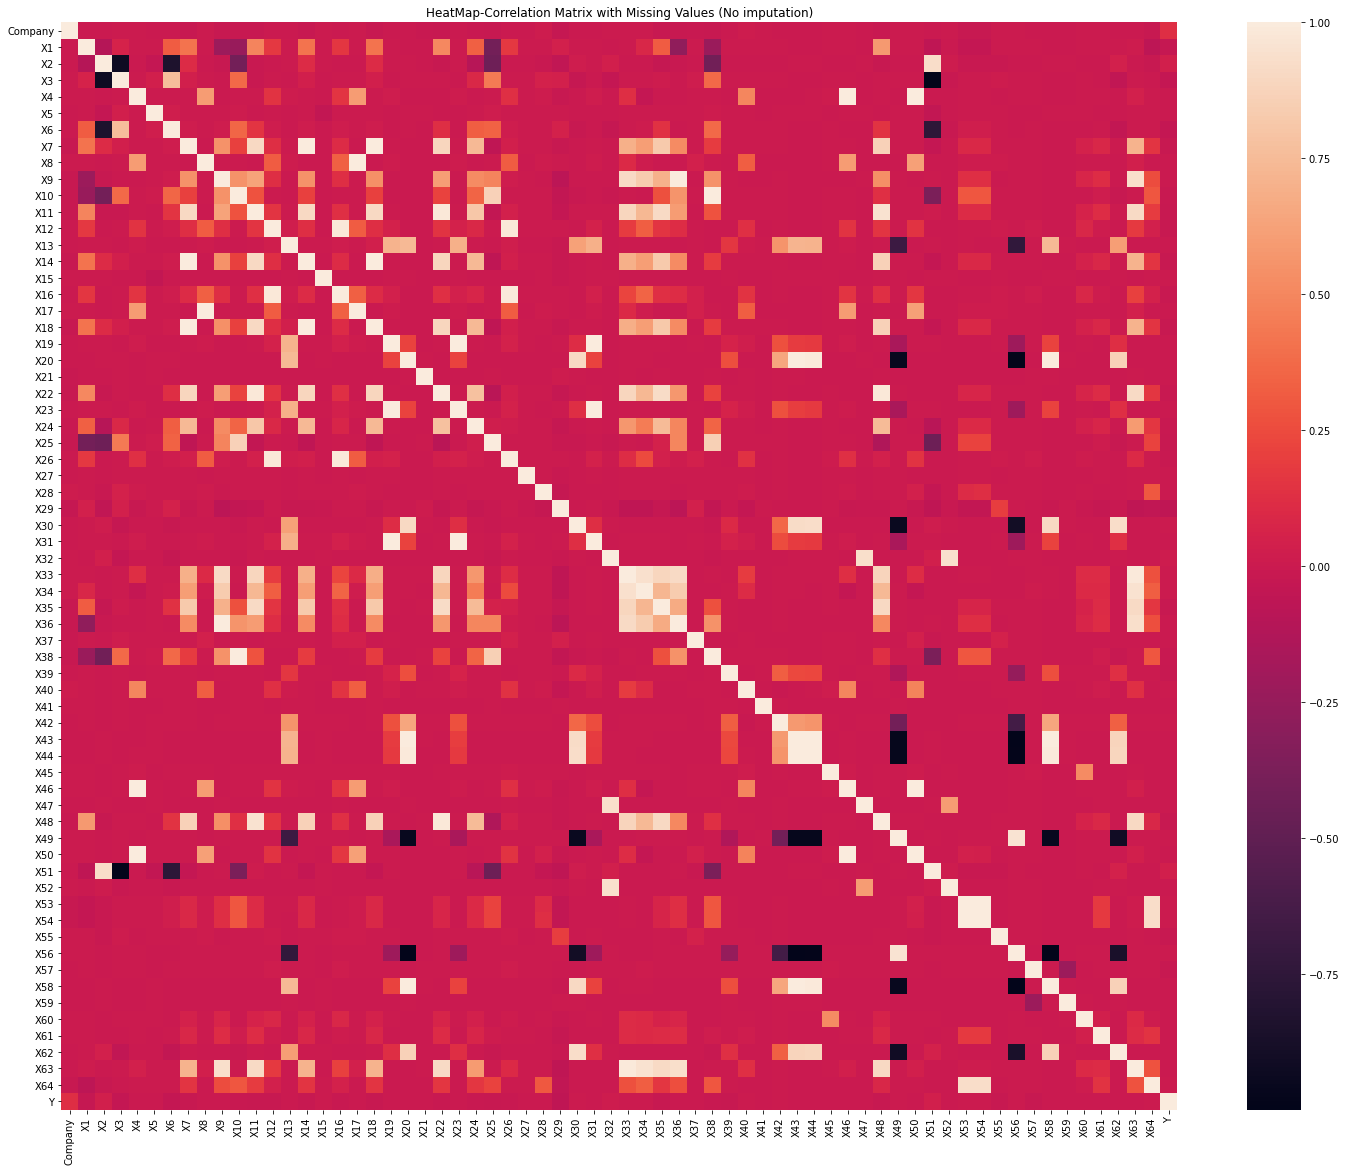

In [15]:
#Check Correlations without imputation (original data)
#to see if imputation affected the corr of features (does not appear to be the case)
df2 = pd.read_csv("https://raw.githubusercontent.com/jteysen/QTW/main/Data/CS_4/CS4_Combined_Data.csv")
df2 = df2.apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(25, 20))
sns.heatmap(df2.corr(), annot=False)
plt.title('HeatMap-Correlation Matrix with Missing Values (No imputation)')

The correlations do not appear affected by the imputation (notably X37 and X21 - imputation based on prediction from another feature would not be possible).

#### Random Forest Model

In [16]:
## split dataset into independent (X) and target (y) variables
y = df['Y']
X = df.drop(['Company','Y'], axis=1) #dropped 'Company' as this is just observation row#
print('Size of target vector: ', y.shape)
print('='*50)
print('Size of explanatory matrix: ',X.shape)

Size of target vector:  (43405,)
Size of explanatory matrix:  (43405, 64)


split between 0 and 1 of binary classes:  
 -----------------
0    41314
1     2091
Name: Y, dtype: int64


<AxesSubplot:title={'center':'Bankruptcy Indicator Counts'}>

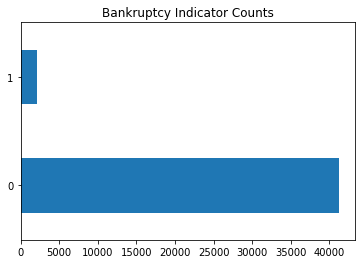

In [17]:
## Check target counts
print("split between 0 and 1 of binary classes:  \n", '-----------------')
print(y.value_counts())

y.value_counts().plot(kind='barh', title='Bankruptcy Indicator Counts')

The target class is heavily imbalanced as far more companies were not flagged as bankrupt (1) - StratifiedKFold should be used to create test and train data, and models should be run with the 'balanced' option to create class weights

In [18]:
## Creating training and test data - 20% witholding for test set (stratified)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Test and train set counts - check that stratification was applied
print('Size of explanatory matrix for Training set: ',X_train.shape)
print('Size of explanatory matrix for Test set: ',X_test.shape)

print("Training set split between 0 and 1 of binary classes:  \n", '-----------------')
print(y_train.value_counts())

print("Test set split between 0 and 1 of binary classes:  \n", '-----------------')
print(y_test.value_counts())

Size of explanatory matrix for Training set:  (34724, 64)
Size of explanatory matrix for Test set:  (8681, 64)
Training set split between 0 and 1 of binary classes:  
 -----------------
0    33051
1     1673
Name: Y, dtype: int64
Test set split between 0 and 1 of binary classes:  
 -----------------
0    8263
1     418
Name: Y, dtype: int64


In [19]:
# Normalize all of the explanatory features with StandardScaler in train and test sets
# *Note: Normalization is not necessary for Tree Ensemble Methods
#from sklearn.preprocessing import StandardScaler
#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

In [23]:
#Grid Search for best Random Forest Parameters (gridsearch will use stratified cv by default if cv# is specified)
#code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def runGridSearchCV(clf_model, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            #RandomForestClassifier(class_weight = 'balanced'), tuned_parameters, n_jobs=-1, scoring='%s' % score
            clf_model, tuned_parameters, n_jobs=-1, scoring='%s' % score
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on training set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on training set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full training set.")
        print("The scores are computed on the full test set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        return clf

In [25]:
%%time
#run gridsearch for random forest
tuned_parameters = [{
    'n_estimators': [10, 100, 300, 500],
    'max_features': [40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,50,100,200]
}]

scores = ['recall'] 
clf = RandomForestClassifier(class_weight = 'balanced')
clf_rf = runGridSearchCV(clf, tuned_parameters, scores)

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 40, 'n_estimators': 500}

Grid scores on training set:

0.606 (+/-0.031) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 40, 'n_estimators': 10}
0.600 (+/-0.047) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 40, 'n_estimators': 100}
0.603 (+/-0.047) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 40, 'n_estimators': 300}
0.604 (+/-0.042) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 40, 'n_estimators': 500}
0.376 (+/-0.049) for {'criterion': 'gini', 'max_depth': 50, 'max_features': 40, 'n_estimators': 10}
0.396 (+/-0.062) for {'criterion': 'gini', 'max_depth': 50, 'max_features': 40, 'n_estimators': 100}
0.395 (+/-0.049) for {'criterion': 'gini', 'max_depth': 50, 'max_features': 40, 'n_estimators': 300}
0.392 (+/-0.058) for {'criterion': 'gini', 'max_depth': 50, 'max_features': 40, 'n_estimators': 500

The above chart shows the best parameters set found on development set based on recall (original run took 4 hours) - max_features was tuned in a separate run to save time. The overall F1-accuracy was 95% with this model based on a maximum achieved recall of .62 on the bankruptcy category. These will be the metrics compared in the boosted models.

The feature importances based on the random forest model are shown below.

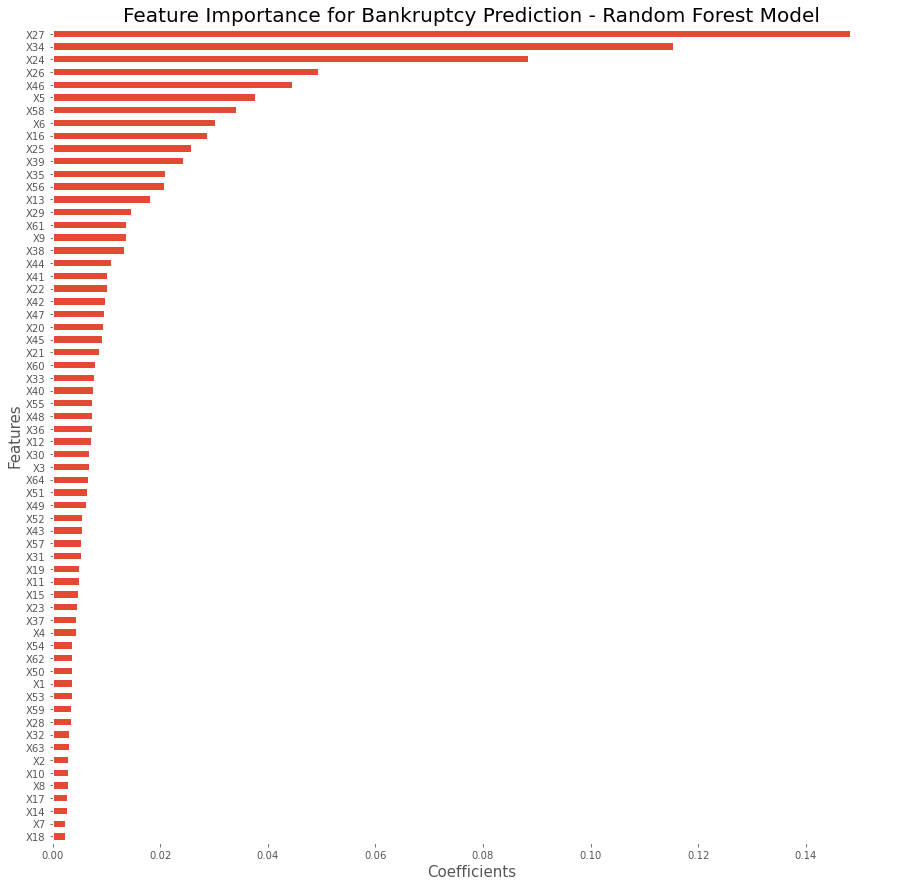

In [28]:
#feature importance for Random Forest Model
plt.style.use('ggplot')
weights = pd.Series(clf_rf.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(15,15))
weights.plot(kind='barh').patch.set_facecolor('white')
plt.ylabel("Features", fontsize=15)
plt.xlabel("Coefficients", fontsize=15)
plt.title('Feature Importance for Bankruptcy Prediction - Random Forest Model', fontsize=20)
plt.show()

### XGBoost

In [19]:
#!pip install xgboost
import xgboost as xgb

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [21]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

We will first evaluate the accuracy using a base set of parameter to XGBoost. We will try with 1000 rounds to see if we get reach early stop.

In [22]:
num_round = 1000
param = {
    'max_depth': 10,
    'objective': 'binary:logistic',
    'eta': 0.01
}

In [43]:
my_model = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 2)

[19:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.68437	train-logloss:0.68426
[1]	eval-logloss:0.67577	train-logloss:0.67545
[2]	eval-logloss:0.66734	train-logloss:0.66684
[3]	eval-logloss:0.65907	train-logloss:0.65842
[4]	eval-logloss:0.65094	train-logloss:0.65017
[5]	eval-logloss:0.64299	train-logloss:0.64207
[6]	eval-logloss:0.63509	train-logloss:0.63406
[7]	eval-logloss:0.62745	train-logloss:0.62624
[8]	eval-logloss:0.61984	train-logloss:0.61852
[9]	eval-logloss:0.61237	train-logloss:0.61090
[10]	eval-logloss:0.60506	train-logloss:0.60347
[11]	eval-logloss:0.59795	train-logloss:0.59620
[12]	eval-logloss:0.59089	train-logloss:0.58903
[13]	eval-logloss:0.58396	train-logloss:0.58198
[14]	eval-logloss:0.57720	tr

[164]	eval-logloss:0.16422	train-logloss:0.14551
[165]	eval-logloss:0.16331	train-logloss:0.14447
[166]	eval-logloss:0.16232	train-logloss:0.14340
[167]	eval-logloss:0.16141	train-logloss:0.14236
[168]	eval-logloss:0.16050	train-logloss:0.14134
[169]	eval-logloss:0.15960	train-logloss:0.14032
[170]	eval-logloss:0.15870	train-logloss:0.13930
[171]	eval-logloss:0.15782	train-logloss:0.13829
[172]	eval-logloss:0.15695	train-logloss:0.13730
[173]	eval-logloss:0.15609	train-logloss:0.13634
[174]	eval-logloss:0.15524	train-logloss:0.13537
[175]	eval-logloss:0.15442	train-logloss:0.13442
[176]	eval-logloss:0.15361	train-logloss:0.13348
[177]	eval-logloss:0.15279	train-logloss:0.13256
[178]	eval-logloss:0.15197	train-logloss:0.13163
[179]	eval-logloss:0.15114	train-logloss:0.13071
[180]	eval-logloss:0.15034	train-logloss:0.12980
[181]	eval-logloss:0.14953	train-logloss:0.12891
[182]	eval-logloss:0.14874	train-logloss:0.12801
[183]	eval-logloss:0.14796	train-logloss:0.12713
[184]	eval-logloss:0

[332]	eval-logloss:0.08895	train-logloss:0.05484
[333]	eval-logloss:0.08879	train-logloss:0.05459
[334]	eval-logloss:0.08865	train-logloss:0.05433
[335]	eval-logloss:0.08849	train-logloss:0.05408
[336]	eval-logloss:0.08835	train-logloss:0.05384
[337]	eval-logloss:0.08821	train-logloss:0.05360
[338]	eval-logloss:0.08805	train-logloss:0.05335
[339]	eval-logloss:0.08793	train-logloss:0.05312
[340]	eval-logloss:0.08781	train-logloss:0.05290
[341]	eval-logloss:0.08768	train-logloss:0.05267
[342]	eval-logloss:0.08755	train-logloss:0.05245
[343]	eval-logloss:0.08743	train-logloss:0.05223
[344]	eval-logloss:0.08729	train-logloss:0.05200
[345]	eval-logloss:0.08717	train-logloss:0.05179
[346]	eval-logloss:0.08704	train-logloss:0.05157
[347]	eval-logloss:0.08694	train-logloss:0.05136
[348]	eval-logloss:0.08682	train-logloss:0.05115
[349]	eval-logloss:0.08670	train-logloss:0.05093
[350]	eval-logloss:0.08658	train-logloss:0.05072
[351]	eval-logloss:0.08647	train-logloss:0.05052
[352]	eval-logloss:0

[500]	eval-logloss:0.07654	train-logloss:0.03212
[501]	eval-logloss:0.07652	train-logloss:0.03207
[502]	eval-logloss:0.07648	train-logloss:0.03197
[503]	eval-logloss:0.07644	train-logloss:0.03190
[504]	eval-logloss:0.07642	train-logloss:0.03184
[505]	eval-logloss:0.07640	train-logloss:0.03175
[506]	eval-logloss:0.07637	train-logloss:0.03169
[507]	eval-logloss:0.07635	train-logloss:0.03163
[508]	eval-logloss:0.07631	train-logloss:0.03157
[509]	eval-logloss:0.07630	train-logloss:0.03150
[510]	eval-logloss:0.07627	train-logloss:0.03142
[511]	eval-logloss:0.07623	train-logloss:0.03132
[512]	eval-logloss:0.07620	train-logloss:0.03127
[513]	eval-logloss:0.07616	train-logloss:0.03118
[514]	eval-logloss:0.07613	train-logloss:0.03112
[515]	eval-logloss:0.07606	train-logloss:0.03103
[516]	eval-logloss:0.07604	train-logloss:0.03098
[517]	eval-logloss:0.07600	train-logloss:0.03089
[518]	eval-logloss:0.07599	train-logloss:0.03084
[519]	eval-logloss:0.07597	train-logloss:0.03078
[520]	eval-logloss:0

[668]	eval-logloss:0.07285	train-logloss:0.02285
[669]	eval-logloss:0.07285	train-logloss:0.02279
[670]	eval-logloss:0.07285	train-logloss:0.02273
[671]	eval-logloss:0.07284	train-logloss:0.02267
[672]	eval-logloss:0.07283	train-logloss:0.02264
[673]	eval-logloss:0.07282	train-logloss:0.02262
[674]	eval-logloss:0.07283	train-logloss:0.02256
[675]	eval-logloss:0.07284	train-logloss:0.02250
[676]	eval-logloss:0.07284	train-logloss:0.02244
[677]	eval-logloss:0.07283	train-logloss:0.02242
[678]	eval-logloss:0.07280	train-logloss:0.02236
[679]	eval-logloss:0.07279	train-logloss:0.02231
[680]	eval-logloss:0.07280	train-logloss:0.02226
[681]	eval-logloss:0.07278	train-logloss:0.02224
[682]	eval-logloss:0.07278	train-logloss:0.02218
[683]	eval-logloss:0.07276	train-logloss:0.02214
[684]	eval-logloss:0.07276	train-logloss:0.02210
[685]	eval-logloss:0.07274	train-logloss:0.02207
[686]	eval-logloss:0.07271	train-logloss:0.02203
[687]	eval-logloss:0.07273	train-logloss:0.02197
[688]	eval-logloss:0

[836]	eval-logloss:0.07184	train-logloss:0.01745
[837]	eval-logloss:0.07184	train-logloss:0.01741
[838]	eval-logloss:0.07183	train-logloss:0.01740
[839]	eval-logloss:0.07182	train-logloss:0.01738
[840]	eval-logloss:0.07182	train-logloss:0.01735
[841]	eval-logloss:0.07179	train-logloss:0.01731
[842]	eval-logloss:0.07181	train-logloss:0.01728
[843]	eval-logloss:0.07180	train-logloss:0.01728
[844]	eval-logloss:0.07180	train-logloss:0.01726
[845]	eval-logloss:0.07179	train-logloss:0.01724
[846]	eval-logloss:0.07179	train-logloss:0.01722
[847]	eval-logloss:0.07178	train-logloss:0.01721
[848]	eval-logloss:0.07178	train-logloss:0.01716
[849]	eval-logloss:0.07177	train-logloss:0.01714
[850]	eval-logloss:0.07176	train-logloss:0.01712
[851]	eval-logloss:0.07177	train-logloss:0.01708
[852]	eval-logloss:0.07177	train-logloss:0.01704
[853]	eval-logloss:0.07177	train-logloss:0.01700
[854]	eval-logloss:0.07176	train-logloss:0.01699
[855]	eval-logloss:0.07178	train-logloss:0.01696
[856]	eval-logloss:0

In [39]:
pred=my_model.predict(dtest)

As we have prediction probabilities, we will look at the precision-recall curve to assess the optimum threshold.

In [30]:
#check predicitions
#pred
from sklearn.metrics import precision_recall_curve

(0.0, 1.0)

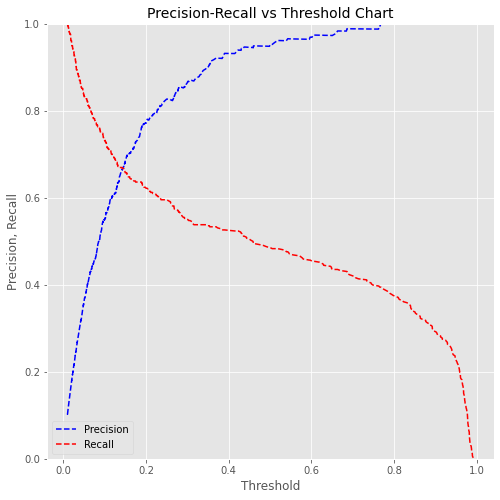

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test,pred) 
#    #retrieve probability of being 1(in second column of probs_y)
# pr_auc = mt.auc(recall, precision)
# print(pr_auc)

plt.figure(figsize=(8,8))
plt.title("Precision-Recall vs Threshold Chart", fontsize=14)
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Threshold looks to be around 0.15. Let us calculate accuracy score based on that threshold.

In [41]:
pred_new = np.where(pred > 0.15, 1, 0)
#pred_new
accuracy_score(pred_new, y_test)

0.9691279806473908

Next, we will do cross-validation on the model to see if it reaches early stopping.

In [33]:
%%time
out = xgb.cv(params=param, dtrain=dtrain, num_boost_round = 1000, nfold=5, verbose_eval=True, early_stopping_rounds = 2)

[18:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[104]	train-logloss:0.23384+0.00074	test-logloss:0.24974+0.00142
[105]	train-logloss:0.23182+0.00074	test-logloss:0.24787+0.00142
[106]	train-logloss:0.22984+0.00073	test-logloss:0.24603+0.00141
[107]	train-logloss:0.22788+0.00073	test-logloss:0.24422+0.00141
[108]	train-logloss:0.22594+0.00073	test-logloss:0.24242+0.00141
[109]	train-logloss:0.22404+0.00073	test-logloss:0.24065+0.00141
[110]	train-logloss:0.22215+0.00073	test-logloss:0.23890+0.00141
[111]	train-logloss:0.22029+0.00073	test-logloss:0.23717+0.00140
[112]	train-logloss:0.21843+0.00072	test-logloss:0.23544+0.00140
[113]	train-logloss:0.21660+0.00071	test-logloss:0.23375+0.00140
[114]	train-logloss:0.21481+0.00072	test-logloss:0.23208+0.00140
[115]	train-logloss:0.21302+0.00071	test-logloss:0.23043+0.00139
[116]	train-logloss:0.21127+0.00071	test-logloss:0.22881+0.00141
[117]	train-logloss:0.20954+0.00070	test-logloss:0.22722+0.00140
[118]	train-logloss:0.20781+0.00069	test-logloss:0.22564+0.00140
[119]	train-logloss:0.206

[231]	train-logloss:0.09310+0.00055	test-logloss:0.12558+0.00142
[232]	train-logloss:0.09254+0.00055	test-logloss:0.12513+0.00142
[233]	train-logloss:0.09199+0.00056	test-logloss:0.12470+0.00142
[234]	train-logloss:0.09143+0.00056	test-logloss:0.12426+0.00142
[235]	train-logloss:0.09088+0.00056	test-logloss:0.12383+0.00142
[236]	train-logloss:0.09032+0.00057	test-logloss:0.12340+0.00143
[237]	train-logloss:0.08978+0.00058	test-logloss:0.12298+0.00144
[238]	train-logloss:0.08925+0.00060	test-logloss:0.12255+0.00146
[239]	train-logloss:0.08872+0.00060	test-logloss:0.12214+0.00146
[240]	train-logloss:0.08819+0.00062	test-logloss:0.12173+0.00146
[241]	train-logloss:0.08767+0.00063	test-logloss:0.12132+0.00146
[242]	train-logloss:0.08715+0.00064	test-logloss:0.12091+0.00147
[243]	train-logloss:0.08665+0.00065	test-logloss:0.12052+0.00146
[244]	train-logloss:0.08614+0.00066	test-logloss:0.12011+0.00147
[245]	train-logloss:0.08565+0.00067	test-logloss:0.11974+0.00146
[246]	train-logloss:0.085

[358]	train-logloss:0.04854+0.00058	test-logloss:0.09477+0.00107
[359]	train-logloss:0.04834+0.00059	test-logloss:0.09467+0.00107
[360]	train-logloss:0.04814+0.00059	test-logloss:0.09456+0.00107
[361]	train-logloss:0.04794+0.00058	test-logloss:0.09446+0.00106
[362]	train-logloss:0.04774+0.00059	test-logloss:0.09436+0.00107
[363]	train-logloss:0.04754+0.00059	test-logloss:0.09425+0.00107
[364]	train-logloss:0.04734+0.00059	test-logloss:0.09415+0.00107
[365]	train-logloss:0.04715+0.00059	test-logloss:0.09405+0.00107
[366]	train-logloss:0.04695+0.00059	test-logloss:0.09395+0.00109
[367]	train-logloss:0.04676+0.00059	test-logloss:0.09385+0.00108
[368]	train-logloss:0.04657+0.00060	test-logloss:0.09375+0.00108
[369]	train-logloss:0.04638+0.00060	test-logloss:0.09365+0.00107
[370]	train-logloss:0.04620+0.00061	test-logloss:0.09355+0.00107
[371]	train-logloss:0.04601+0.00061	test-logloss:0.09345+0.00107
[372]	train-logloss:0.04583+0.00061	test-logloss:0.09334+0.00106
[373]	train-logloss:0.045

[485]	train-logloss:0.03184+0.00088	test-logloss:0.08673+0.00148
[486]	train-logloss:0.03176+0.00087	test-logloss:0.08668+0.00150
[487]	train-logloss:0.03168+0.00087	test-logloss:0.08665+0.00150
[488]	train-logloss:0.03160+0.00087	test-logloss:0.08661+0.00151
[489]	train-logloss:0.03152+0.00087	test-logloss:0.08657+0.00152
[490]	train-logloss:0.03144+0.00088	test-logloss:0.08654+0.00154
[491]	train-logloss:0.03135+0.00087	test-logloss:0.08650+0.00154
[492]	train-logloss:0.03128+0.00087	test-logloss:0.08648+0.00155
[493]	train-logloss:0.03120+0.00087	test-logloss:0.08644+0.00156
[494]	train-logloss:0.03112+0.00086	test-logloss:0.08642+0.00157
[495]	train-logloss:0.03105+0.00087	test-logloss:0.08640+0.00158
[496]	train-logloss:0.03097+0.00086	test-logloss:0.08637+0.00157
[497]	train-logloss:0.03090+0.00086	test-logloss:0.08636+0.00158
[498]	train-logloss:0.03082+0.00086	test-logloss:0.08633+0.00160
[499]	train-logloss:0.03076+0.00086	test-logloss:0.08630+0.00161
[500]	train-logloss:0.030

[612]	train-logloss:0.02370+0.00097	test-logloss:0.08371+0.00217
[613]	train-logloss:0.02366+0.00097	test-logloss:0.08370+0.00218
[614]	train-logloss:0.02361+0.00097	test-logloss:0.08367+0.00218
[615]	train-logloss:0.02356+0.00098	test-logloss:0.08366+0.00220
[616]	train-logloss:0.02352+0.00098	test-logloss:0.08366+0.00220
[617]	train-logloss:0.02347+0.00098	test-logloss:0.08364+0.00221
[618]	train-logloss:0.02343+0.00098	test-logloss:0.08363+0.00222
[619]	train-logloss:0.02338+0.00098	test-logloss:0.08362+0.00222
[620]	train-logloss:0.02333+0.00098	test-logloss:0.08359+0.00222
[621]	train-logloss:0.02329+0.00098	test-logloss:0.08358+0.00222
[622]	train-logloss:0.02324+0.00098	test-logloss:0.08357+0.00224
[623]	train-logloss:0.02319+0.00098	test-logloss:0.08355+0.00226
[624]	train-logloss:0.02314+0.00099	test-logloss:0.08353+0.00225
[625]	train-logloss:0.02309+0.00099	test-logloss:0.08351+0.00226
[626]	train-logloss:0.02304+0.00099	test-logloss:0.08349+0.00225
[627]	train-logloss:0.022

Looks like we did reach early stopping condition. Let us look at the learning rate to see if it stabilized.

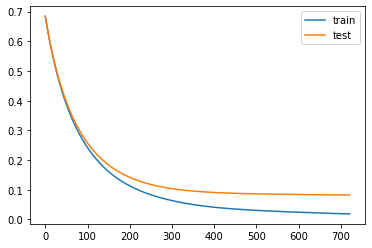

In [34]:
plt.plot(out['train-logloss-mean'], label='train')
plt.plot(out['test-logloss-mean'], label='test')
plt.legend()
plt.show()

The test learning rate did flatten indicating it is better to stop at this point to avoid overfitting to the training data.

Let us do the hyperparameter tuning now to assess the best parameters.

In [24]:
%%time
xgb_param = [{
    'max_depth': [5, 10, 15],
    'objective': ['binary:logistic'],
    'eta': [0.001, 0.05, 0.01]
}]
xgb_scores = ['recall'] #training based on recall with goal of specifically identifying bankruptcy situations
xgb_model = xgb.XGBClassifier()
#clf = RandomForestClassifier(class_weight = 'balanced')
clf_xgb = runGridSearchCV(xgb_model, xgb_param, xgb_scores)

# Tuning hyper-parameters for recall

[16:58:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on training set:

{'eta': 0.05, 'max_depth': 10, 'objective': 'binary:logistic'}

Grid scores on training set:

0.250 (+/-0.052) for {'eta': 0.001, 'max_depth': 5, 'objective': 'binary:logistic'}
0.375 (+/-0.067) for {'eta': 0.001, 'max_depth': 10, 'objective': 'binary:logistic'}
0.405 (+/-0.034) for {'eta': 0.001, 'max_depth': 15, 'objective': 'binary:logistic'}
0.394 (+/-0.045) for {'eta': 0.05, 'max_depth': 5, 'objective': 'binary:logistic'}
0.468 (+/-0.021) for {'eta': 0.05, 'max_depth': 10, 'objective': 'binary:logistic'}
0.460 (+/-0.031) for {'eta': 0.05, 'max_depth': 15, 'objective': 'binary:logistic'}
0.282 (+/

Looks like we can get up to 98% accuracy by tuning the hyperparamters. As the Grid Search took time, let us assess Randomized Search now to see if it saves us time.

Below shows a randomized grid search for RF for comparison to the full grid search run above for comparison. This will randomly select hyperparameter combinations instead of running all possible combinations, which should reults in faster run time.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
def runRandomizedSearchCV(clf_model, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = RandomizedSearchCV(
            #RandomForestClassifier(class_weight = 'balanced'), tuned_parameters, n_jobs=-1, scoring='%s' % score
            clf_model, tuned_parameters, n_jobs=-1, scoring='%s' % score, cv=5, n_iter=10
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on training set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on training set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full training set.")
        print("The scores are computed on the full test set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        return clf


In [45]:
%%time
#Run randomized search for RF
clf_rf2 = runRandomizedSearchCV(clf, tuned_parameters, scores)

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'n_estimators': 10, 'max_features': 40, 'max_depth': 10, 'criterion': 'gini'}

Grid scores on training set:

0.614 (+/-0.042) for {'n_estimators': 100, 'max_features': 40, 'max_depth': 10, 'criterion': 'gini'}
0.389 (+/-0.067) for {'n_estimators': 100, 'max_features': 40, 'max_depth': 50, 'criterion': 'gini'}
0.393 (+/-0.074) for {'n_estimators': 10, 'max_features': 40, 'max_depth': 50, 'criterion': 'entropy'}
0.614 (+/-0.044) for {'n_estimators': 10, 'max_features': 40, 'max_depth': 10, 'criterion': 'gini'}
0.391 (+/-0.053) for {'n_estimators': 300, 'max_features': 40, 'max_depth': 200, 'criterion': 'gini'}
0.420 (+/-0.070) for {'n_estimators': 300, 'max_features': 40, 'max_depth': 50, 'criterion': 'entropy'}
0.392 (+/-0.051) for {'n_estimators': 100, 'max_features': 40, 'max_depth': 200, 'criterion': 'gini'}
0.416 (+/-0.062) for {'n_estimators': 100, 'max_features': 40, 'max_depth': 200, 'criterion': '

Below shows a randomized grid search for the xgboost model. This will randomly select hyperparameter combinations instead of running all possible combinations, which should reults in faster run time.

In [26]:
%%time
#Run randomized search for XGB
clf_xgb2 = runRandomizedSearchCV(xgb_model, xgb_param, xgb_scores)

# Tuning hyper-parameters for recall

[17:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on training set:

{'objective': 'binary:logistic', 'max_depth': 10, 'eta': 0.05}

Grid scores on training set:

0.250 (+/-0.052) for {'objective': 'binary:logistic', 'max_depth': 5, 'eta': 0.001}
0.375 (+/-0.067) for {'objective': 'binary:logistic', 'max_depth': 10, 'eta': 0.001}
0.405 (+/-0.034) for {'objective': 'binary:logistic', 'max_depth': 15, 'eta': 0.001}
0.394 (+/-0.045) for {'objective': 'binary:logistic', 'max_depth': 5, 'eta': 0.05}
0.468 (+/-0.021) for {'objective': 'binary:logistic', 'max_depth': 10, 'eta': 0.05}
0.460 (+/-0.031) for {'objective': 'binary:logistic', 'max_depth': 15, 'eta': 0.05}
0.282 (+/

In case of XGBoost, there doesn't seem to be much to gain using Randomized Search probably due to the less number of parameters we are trying to tune. We will go ahead and assess accuracy using this updated model.

In [47]:
#clf_xgb2

In [36]:
num_round = 1000
mymodel_xgb_2 = xgb.train(clf_xgb2.best_params_, dtrain, num_round, evallist, early_stopping_rounds = 2)

[18:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.65014	train-logloss:0.64935
[1]	eval-logloss:0.61125	train-logloss:0.60965
[2]	eval-logloss:0.57536	train-logloss:0.57315
[3]	eval-logloss:0.54267	train-logloss:0.53989
[4]	eval-logloss:0.51295	train-logloss:0.50963
[5]	eval-logloss:0.48553	train-logloss:0.48162
[6]	eval-logloss:0.45997	train-logloss:0.45550
[7]	eval-logloss:0.43645	train-logloss:0.43141
[8]	eval-logloss:0.41478	train-logloss:0.40930
[9]	eval-logloss:0.39449	train-logloss:0.38853
[10]	eval-logloss:0.37578	train-logloss:0.36916
[11]	eval-logloss:0.35841	train-logloss:0.35125
[12]	eval-logloss:0.34229	train-logloss:0.33443
[13]	eval-logloss:0.32725	train-logloss:0.31876
[14]	eval-logloss:0.31329	tr

[164]	eval-logloss:0.07229	train-logloss:0.01750
[165]	eval-logloss:0.07227	train-logloss:0.01743
[166]	eval-logloss:0.07231	train-logloss:0.01733
[167]	eval-logloss:0.07229	train-logloss:0.01708
[168]	eval-logloss:0.07228	train-logloss:0.01688
[169]	eval-logloss:0.07228	train-logloss:0.01680
[170]	eval-logloss:0.07234	train-logloss:0.01658
[171]	eval-logloss:0.07232	train-logloss:0.01650
[172]	eval-logloss:0.07238	train-logloss:0.01637
[173]	eval-logloss:0.07236	train-logloss:0.01616
[174]	eval-logloss:0.07226	train-logloss:0.01593
[175]	eval-logloss:0.07224	train-logloss:0.01573
[176]	eval-logloss:0.07217	train-logloss:0.01558
[177]	eval-logloss:0.07211	train-logloss:0.01545
[178]	eval-logloss:0.07212	train-logloss:0.01535
[179]	eval-logloss:0.07204	train-logloss:0.01529
[180]	eval-logloss:0.07208	train-logloss:0.01519
[181]	eval-logloss:0.07206	train-logloss:0.01502
[182]	eval-logloss:0.07197	train-logloss:0.01487
[183]	eval-logloss:0.07191	train-logloss:0.01471
[184]	eval-logloss:0

[332]	eval-logloss:0.07166	train-logloss:0.00646
[333]	eval-logloss:0.07164	train-logloss:0.00643
[334]	eval-logloss:0.07167	train-logloss:0.00641
[335]	eval-logloss:0.07164	train-logloss:0.00639
[336]	eval-logloss:0.07166	train-logloss:0.00635
[337]	eval-logloss:0.07168	train-logloss:0.00631
[338]	eval-logloss:0.07170	train-logloss:0.00629
[339]	eval-logloss:0.07168	train-logloss:0.00626
[340]	eval-logloss:0.07166	train-logloss:0.00623
[341]	eval-logloss:0.07166	train-logloss:0.00622
[342]	eval-logloss:0.07171	train-logloss:0.00617
[343]	eval-logloss:0.07175	train-logloss:0.00615
[344]	eval-logloss:0.07176	train-logloss:0.00611
[345]	eval-logloss:0.07179	train-logloss:0.00609
[346]	eval-logloss:0.07178	train-logloss:0.00605
[347]	eval-logloss:0.07172	train-logloss:0.00601
[348]	eval-logloss:0.07173	train-logloss:0.00600
[349]	eval-logloss:0.07173	train-logloss:0.00597
[350]	eval-logloss:0.07175	train-logloss:0.00596
[351]	eval-logloss:0.07178	train-logloss:0.00593
[352]	eval-logloss:0

[500]	eval-logloss:0.07389	train-logloss:0.00343
[501]	eval-logloss:0.07392	train-logloss:0.00342
[502]	eval-logloss:0.07392	train-logloss:0.00341
[503]	eval-logloss:0.07393	train-logloss:0.00339
[504]	eval-logloss:0.07396	train-logloss:0.00339
[505]	eval-logloss:0.07396	train-logloss:0.00337
[506]	eval-logloss:0.07394	train-logloss:0.00335
[507]	eval-logloss:0.07395	train-logloss:0.00334
[508]	eval-logloss:0.07395	train-logloss:0.00334
[509]	eval-logloss:0.07398	train-logloss:0.00332
[510]	eval-logloss:0.07395	train-logloss:0.00331
[511]	eval-logloss:0.07394	train-logloss:0.00330
[512]	eval-logloss:0.07395	train-logloss:0.00330
[513]	eval-logloss:0.07394	train-logloss:0.00328
[514]	eval-logloss:0.07392	train-logloss:0.00327
[515]	eval-logloss:0.07389	train-logloss:0.00325
[516]	eval-logloss:0.07389	train-logloss:0.00325
[517]	eval-logloss:0.07391	train-logloss:0.00324
[518]	eval-logloss:0.07394	train-logloss:0.00323
[519]	eval-logloss:0.07391	train-logloss:0.00321
[520]	eval-logloss:0

[668]	eval-logloss:0.07519	train-logloss:0.00218
[669]	eval-logloss:0.07519	train-logloss:0.00218
[670]	eval-logloss:0.07520	train-logloss:0.00218
[671]	eval-logloss:0.07525	train-logloss:0.00217
[672]	eval-logloss:0.07528	train-logloss:0.00217
[673]	eval-logloss:0.07528	train-logloss:0.00216
[674]	eval-logloss:0.07529	train-logloss:0.00216
[675]	eval-logloss:0.07528	train-logloss:0.00215
[676]	eval-logloss:0.07533	train-logloss:0.00215
[677]	eval-logloss:0.07533	train-logloss:0.00215
[678]	eval-logloss:0.07534	train-logloss:0.00214
[679]	eval-logloss:0.07535	train-logloss:0.00214
[680]	eval-logloss:0.07535	train-logloss:0.00214
[681]	eval-logloss:0.07538	train-logloss:0.00214
[682]	eval-logloss:0.07539	train-logloss:0.00213
[683]	eval-logloss:0.07543	train-logloss:0.00212
[684]	eval-logloss:0.07545	train-logloss:0.00212
[685]	eval-logloss:0.07543	train-logloss:0.00212
[686]	eval-logloss:0.07544	train-logloss:0.00211
[687]	eval-logloss:0.07546	train-logloss:0.00211
[688]	eval-logloss:0

[836]	eval-logloss:0.07713	train-logloss:0.00158
[837]	eval-logloss:0.07713	train-logloss:0.00158
[838]	eval-logloss:0.07716	train-logloss:0.00157
[839]	eval-logloss:0.07716	train-logloss:0.00157
[840]	eval-logloss:0.07715	train-logloss:0.00157
[841]	eval-logloss:0.07716	train-logloss:0.00157
[842]	eval-logloss:0.07717	train-logloss:0.00156
[843]	eval-logloss:0.07719	train-logloss:0.00156
[844]	eval-logloss:0.07722	train-logloss:0.00156
[845]	eval-logloss:0.07721	train-logloss:0.00156
[846]	eval-logloss:0.07720	train-logloss:0.00156
[847]	eval-logloss:0.07721	train-logloss:0.00155
[848]	eval-logloss:0.07725	train-logloss:0.00155
[849]	eval-logloss:0.07728	train-logloss:0.00155
[850]	eval-logloss:0.07727	train-logloss:0.00154
[851]	eval-logloss:0.07727	train-logloss:0.00154
[852]	eval-logloss:0.07727	train-logloss:0.00154
[853]	eval-logloss:0.07730	train-logloss:0.00154
[854]	eval-logloss:0.07729	train-logloss:0.00154
[855]	eval-logloss:0.07730	train-logloss:0.00153
[856]	eval-logloss:0

In [37]:
xgb2_pred=mymodel_xgb_2.predict(dtest)

(0.0, 1.0)

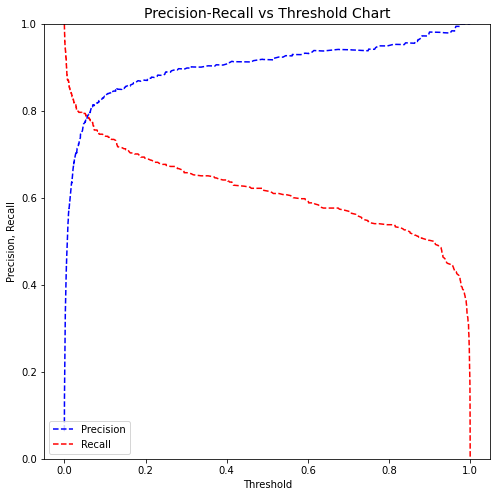

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test,xgb2_pred) 
plt.figure(figsize=(8,8))
plt.title("Precision-Recall vs Threshold Chart", fontsize=14)
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [39]:
#threshold seems to be about 0.05
pred_xgb2_new = np.where(xgb2_pred > 0.1, 1, 0)
#pred_new
accuracy_score(pred_xgb2_new, y_test)

0.9804170026494643

We will now do one final cross validation using the updated model.

In [40]:
%%time
out = xgb.cv(params=clf_xgb2.best_params_, dtrain=dtrain, num_boost_round = 1000, nfold=5, verbose_eval=True, early_stopping_rounds = 2)

[18:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[104]	train-logloss:0.02849+0.00095	test-logloss:0.08507+0.00185
[105]	train-logloss:0.02822+0.00094	test-logloss:0.08499+0.00188
[106]	train-logloss:0.02786+0.00088	test-logloss:0.08487+0.00196
[107]	train-logloss:0.02755+0.00093	test-logloss:0.08478+0.00198
[108]	train-logloss:0.02720+0.00088	test-logloss:0.08464+0.00196
[109]	train-logloss:0.02688+0.00092	test-logloss:0.08457+0.00200
[110]	train-logloss:0.02657+0.00092	test-logloss:0.08446+0.00199
[111]	train-logloss:0.02625+0.00092	test-logloss:0.08438+0.00202
[112]	train-logloss:0.02594+0.00096	test-logloss:0.08426+0.00206
[113]	train-logloss:0.02566+0.00096	test-logloss:0.08420+0.00207
[114]	train-logloss:0.02538+0.00093	test-logloss:0.08412+0.00209
[115]	train-logloss:0.02510+0.00093	test-logloss:0.08401+0.00211
[116]	train-logloss:0.02479+0.00091	test-logloss:0.08389+0.00216
[117]	train-logloss:0.02449+0.00095	test-logloss:0.08382+0.00228
[118]	train-logloss:0.02423+0.00096	test-logloss:0.08372+0.00229
[119]	train-logloss:0.023

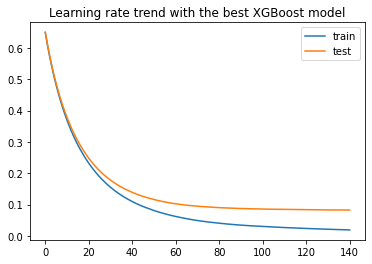

In [44]:
plt.plot(out['train-logloss-mean'], label='train')
plt.plot(out['test-logloss-mean'], label='test')
plt.legend()
plt.title('Learning rate trend with the best XGBoost model')
plt.show()

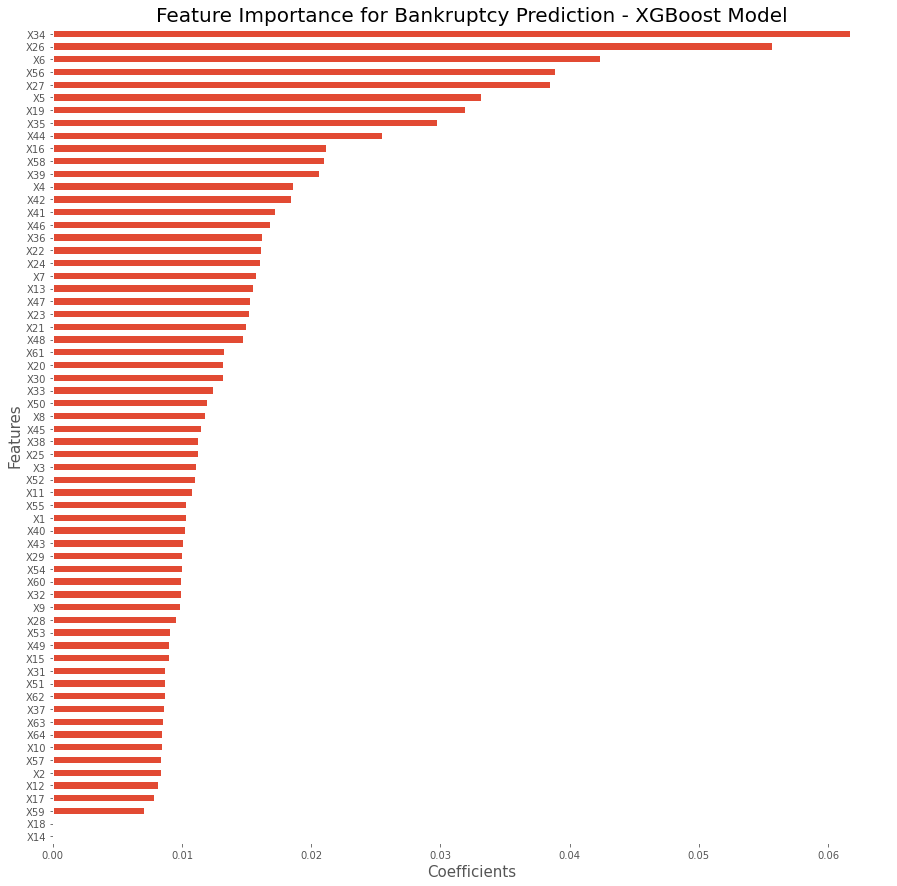

In [46]:
#feature importance for Random Forest Model
plt.style.use('ggplot')
weights = pd.Series(clf_xgb2.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(15,15))
weights.plot(kind='barh').patch.set_facecolor('white')
plt.ylabel("Features", fontsize=15)
plt.xlabel("Coefficients", fontsize=15)
plt.title('Feature Importance for Bankruptcy Prediction - XGBoost Model', fontsize=20)
plt.show()

### References

[1] Zięba, Maciej et al. *Ensemble boosted trees with synthetic features generation in application to bankruptcy prediction*. Expert Systems with Applications,Volume 58, 2016, Pages 93-101, ISSN 0957-4174. https://www.sciencedirect.com/science/article/abs/pii/S0957417416301592?via%3Dihub

[2] EMIS Website. https://www.emis.com/about

[3] *Polish companies bankruptcy data Data Set*. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data